In [1]:
import torch
import os
import random
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)

# Set the random seed [1]
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Question 2

## Part 1

In [2]:
df2 = pd.read_csv('FeedForward_Data_ellipse.csv', header=None, names=['feature_1', 'feature_2', 'label'])
df2.head()

,feature_1,feature_2,label
0,0.008936,-0.292380,0
1,-0.009403,-0.281620,0
2,-0.620040,0.076616,1
3,0.555020,-0.612740,1
4,0.221360,-0.249130,0


<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

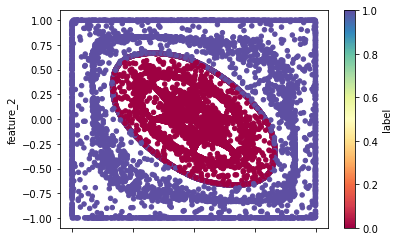

In [3]:
# Plot the raw data
df2.plot('feature_1', 'feature_2', kind='scatter', c='label', cmap=plt.cm.Spectral)

In [4]:
# Code provided in the attachment with revision
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 80)
        self.fc2 = nn.Linear(80, 65)
        self.fc3 = nn.Linear(65, 50)
        self.fc4 = nn.Linear(50, 35)
        self.fc5 = nn.Linear(35, 20)
        self.fc6 = nn.Linear(20, 10)
        self.fc7 = nn.Linear(10, 5)
        self.fc8 = nn.Linear(5, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return F.log_softmax(x)
#         return F.softmax(x)

In [5]:
def train(x, y, lr, nepoch):
    net = Net()
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.95)
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.NLLLoss()
    accuracy_list = []
    loss_list = []
    learning_rate_changed = False
    temp_model = None
    for e in range(nepoch):
        # When accuracy becomes above 0.91, reduce the learning rate for more precision
        if e > 0:
            if accuracy_list[-1] > 0.91 and learning_rate_changed==False:
                for g in optimizer.param_groups:
                    g['lr'] = g['lr']/2
                    learning_rate_changed = True
        optimizer.zero_grad()
        net_out = net(x)
        loss = criterion(net_out, y)
        loss.backward()
        optimizer.step()
        net_out = net(x)
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        correctidx = pred.eq(y.data) 
        ncorrect = correctidx.sum()
        accuracy = ncorrect.item()/len(x)
        if e % 1000 == 0 or e == nepoch-1:
            print('Epoch ', e, 'Loss ', loss.item())
            print('Training accuracy is ', accuracy)
        # Save the model with highest accuracy
        if e > 0: # save the model with local minimum loss (local maximum accuracy)
            if accuracy > max(accuracy_list):
                temp_model = net
        accuracy_list.append(accuracy)
        loss_list.append(loss.item())
        if accuracy > 0.975: # set target accuracy 
            break
    max_accuracy = max(accuracy_list)
    num_e = accuracy_list.index(max_accuracy)
    print(f'Highest accuracy ever reached was {max_accuracy} at epoch {num_e}. The loss is {loss_list[num_e]}') 
    return temp_model

In [6]:
x = df2.values[:, 0:2]
x = torch.tensor(x, dtype = torch.float)
y = df2.values[:, 2]
y = torch.tensor(y, dtype = torch.long)

In [7]:
model = train(x, y, 0.01, 25000)

/var/folders/m5/_6922_t17t748s81dyxlhfpm0000gn/T/ipykernel_77939/3005631033.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch  0 Loss  0.6941137313842773
Training accuracy is  0.4434344951923077
Epoch  1000 Loss  0.18890826404094696
Training accuracy is  0.8998647836538461
Epoch  2000 Loss  0.18158023059368134
Training accuracy is  0.9006159855769231
Epoch  3000 Loss  0.18875741958618164
Training accuracy is  0.8800330528846154
Epoch  4000 Loss  0.184473916888237
Training accuracy is  0.9045973557692307
Epoch  5000 Loss  0.1817168891429901
Training accuracy is  0.9007662259615384
Epoch  6000 Loss  0.20498670637607574
Training accuracy is  0.8952073317307693
Epoch  7000 Loss  0.21425826847553253
Training accuracy is  0.8946063701923077
Epoch  8000 Loss  0.18700000643730164
Training accuracy is  0.9000901442307693
Epoch  9000 Loss  0.19141975045204163
Training accuracy is  0.8991887019230769
Epoch  10000 Loss  0.19110265374183655
Training accuracy is  0.8995643028846154
Epoch  11000 Loss  0.17587019503116608
Training accuracy is  0.9009915865384616
Epoch  12000 Loss  0.1772506982088089
Training accuracy i

In [8]:
def plot_decision_boundary(clf, X, y):
    net = clf
    x_min, x_max = -1.0, 1.0
    y_min, y_max = -1.0, 1.0
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_out = net(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype = torch.float))
    Z = X_out.data.max(1)[1]
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, s = 1)
    plt.show()
    plt.close()

/var/folders/m5/_6922_t17t748s81dyxlhfpm0000gn/T/ipykernel_77939/3005631033.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


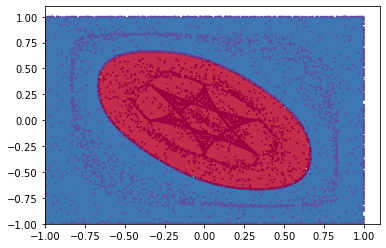

In [9]:
plot_decision_boundary(model, x, y)

Throughout the whole training process, the best accuracy reached was 0.9756, and the lowest corresponding loss is 0.1609. The network has 7 hidden layers, and the type of activation function is relu. For hidden layers 1 through 7, the number of neurons are 80, 65, 50, 35, 20, 10, 5 respectively. The model uses stochastic gradient descent as the optimizer. 

## Part 2

In [10]:
# Set the random seed [1]
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

df3 = pd.read_csv('FeedForward_Data_hexa.csv', header=None, names=['feature_1', 'feature_2', 'label'])
df3.head()

,feature_1,feature_2,label
0,0.008936,-0.292380,1
1,-0.009403,-0.281620,1
2,-0.620040,0.076616,1
3,0.555020,-0.612740,1
4,0.221360,-0.249130,1


<AxesSubplot:xlabel='feature_1', ylabel='feature_2'>

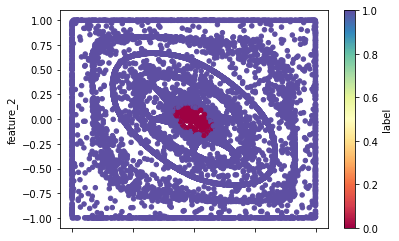

In [11]:
# Plot the raw data
df3.plot('feature_1', 'feature_2', kind='scatter', c='label', cmap=plt.cm.Spectral)

In [12]:
# Code provided in the attachment with revision
class Net_2b(nn.Module):
    
    def __init__(self):
        super(Net_2b, self).__init__()
        self.fc1 = nn.Linear(2, 100)
        self.fc2 = nn.Linear(100, 85)
        self.fc3 = nn.Linear(85, 70)
        self.fc4 = nn.Linear(70, 55)
        self.fc5 = nn.Linear(55, 40)
        self.fc6 = nn.Linear(40, 25)
        self.fc7 = nn.Linear(25, 10)
        self.fc8 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.relu(self.fc6(x))
        x = F.relu(self.fc7(x))
        x = self.fc8(x)
        return F.log_softmax(x)
#         return F.softmax(x)

In [13]:
def train_2b(x, y, lr, nepoch):
    net = Net_2b()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.NLLLoss()
    accuracy_list = []
    loss_list = []
    learning_rate_changed = False
    temp_model = None
    for e in range(nepoch):
        # When accuracy becomes above 0.91, reduce the learning rate for more precision
        if e > 0:
            if accuracy_list[-1] > 0.91 and learning_rate_changed==False:
                for g in optimizer.param_groups:
                    g['lr'] = g['lr']/2
                    learning_rate_changed = True
        optimizer.zero_grad()
        net_out = net(x)
        loss = criterion(net_out, y)
        loss.backward()
        optimizer.step()
        net_out = net(x)
        pred = net_out.data.max(1)[1]  # get the index of the max log-probability
        correctidx = pred.eq(y.data) 
        ncorrect = correctidx.sum()
        accuracy = ncorrect.item()/len(x)
        if e % 1000 == 0 or e == nepoch-1:
            print('Epoch ', e, 'Loss ', loss.item())
            print('Training accuracy is ', accuracy)
        # Save the model with highest accuracy
        if e > 0:
            if accuracy > max(accuracy_list):
                temp_model = net
        accuracy_list.append(accuracy)
        loss_list.append(loss.item())
        if accuracy == 1: # set target accuracy 
            break
    max_accuracy = max(accuracy_list)
    num_e = accuracy_list.index(max_accuracy)
    print(f'Highest accuracy ever reached was {max_accuracy} at epoch {num_e}. The loss is {loss_list[num_e]}') 
    return temp_model

In [14]:
x = df3.values[:, 0:2]
x = torch.tensor(x, dtype = torch.float)
y = df3.values[:, 2]
y = torch.tensor(y, dtype = torch.long)

In [15]:
model = train_2b(x, y, 0.01, 10000)

/var/folders/m5/_6922_t17t748s81dyxlhfpm0000gn/T/ipykernel_77939/3798325576.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Epoch  0 Loss  0.7211758494377136
Training accuracy is  0.9405799278846154
Epoch  1000 Loss  0.04226456210017204
Training accuracy is  0.9752103365384616
Epoch  2000 Loss  0.04171620309352875
Training accuracy is  0.9785907451923077
Epoch  3000 Loss  0.045059286057949066
Training accuracy is  0.9766376201923077
Epoch  4000 Loss  0.05297552049160004
Training accuracy is  0.9743088942307693
Epoch  5000 Loss  0.03932597488164902
Training accuracy is  0.9862530048076923
Epoch  6000 Loss  0.03993677720427513
Training accuracy is  0.9838491586538461
Epoch  7000 Loss  0.0721174031496048
Training accuracy is  0.9577824519230769
Epoch  8000 Loss  0.053894128650426865
Training accuracy is  0.9741586538461539
Epoch  9000 Loss  0.046735815703868866
Training accuracy is  0.9755108173076923
Epoch  9999 Loss  0.03760667145252228
Training accuracy is  0.9909855769230769
Highest accuracy ever reached was 0.9921875 at epoch 9375. The loss is 0.033159758895635605


/var/folders/m5/_6922_t17t748s81dyxlhfpm0000gn/T/ipykernel_77939/3798325576.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


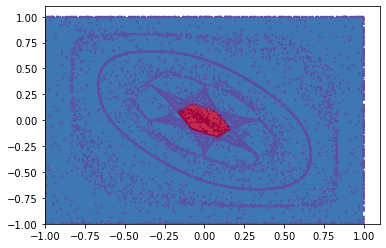

In [16]:
plot_decision_boundary(model, x, y)

Throughout the whole training process, the best accuracy reached was 0.992, and the lowest corresponding loss is 0.0332. The network has 7 hidden layers, and the type of activation function is relu. For hidden layers 1 through 7, the number of neurons are 100, 85, 70, 55, 40, 25, 10 respectively. The model uses Adam as the optimizer. 

# Reference

[1] For setting random seed: https://clay-atlas.com/us/blog/2021/08/24/pytorch-en-set-seed-reproduce/ <br />
[2] Sample Code Given